In [38]:
from utils import * 
from config import parameters

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
import math
from statsmodels.tsa.stattools import grangercausalitytests

from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

processed_list_pkl_filepath = os.path.join(parameters.output_base_dir, 'topn_50_rolling_3_period_x_y_dict.csv') 
[period_dict, proposed_data_x_dict, fred_data_y_dict] = load_pkl(processed_list_pkl_filepath)

Completed loading: /home/dmlab/jihye/GIT/bis_speeches_text_bigram_frequency/output/topn_50_rolling_3_period_x_y_dict.csv


### Y (Percentage Change of Unemployment Rate) only
https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

In [18]:
# test
fred_data_y_dict.keys()

dict_keys(['gdp', 'unemployment', 'unemployment_not_adjusted', 'interest_rate', 'ted_spread', 'djia'])

In [19]:
# test
len(fred_data_y_dict['unemployment_not_adjusted'])

84

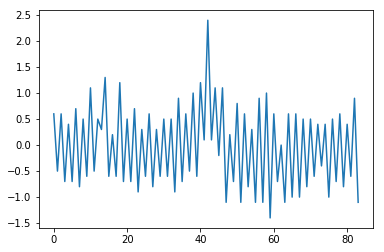

In [20]:
# test
dataset = pd.Series(fred_data_y_dict['unemployment_not_adjusted'])
plt.plot(dataset)
plt.show()

In [32]:
dataset = pd.Series(fred_data_y_dict['unemployment_not_adjusted']).values   # pd.Series -> numpy.ndarray
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

56 28


In [39]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Epoch 1/200
 - 0s - loss: 0.9782
Epoch 2/200
 - 0s - loss: 0.8720
Epoch 3/200
 - 0s - loss: 0.7848
Epoch 4/200
 - 0s - loss: 0.7122
Epoch 5/200
 - 0s - loss: 0.6545
Epoch 6/200
 - 0s - loss: 0.6083
Epoch 7/200
 - 0s - loss: 0.5682
Epoch 8/200
 - 0s - loss: 0.5357
Epoch 9/200
 - 0s - loss: 0.5071
Epoch 10/200
 - 0s - loss: 0.4821
Epoch 11/200
 - 0s - loss: 0.4605
Epoch 12/200
 - 0s - loss: 0.4402
Epoch 13/200
 - 0s - loss: 0.4225
Epoch 14/200
 - 0s - loss: 0.4076
Epoch 15/200
 - 0s - loss: 0.3942
Epoch 16/200
 - 0s - loss: 0.3828
Epoch 17/200
 - 0s - loss: 0.3727
Epoch 18/200
 - 0s - loss: 0.3637
Epoch 19/200
 - 0s - loss: 0.3580
Epoch 20/200
 - 0s - loss: 0.3510
Epoch 21/200
 - 0s - loss: 0.3455
Epoch 22/200
 - 0s - loss: 0.3418
Epoch 23/200
 - 0s - loss: 0.3382
Epoch 24/200
 - 0s - loss: 0.3352
Epoch 25/200
 - 0s - loss: 0.3327
Epoch 26/200
 - 0s - loss: 0.3318
Epoch 27/200
 - 0s - loss: 0.3295
Epoch 28/200
 - 0s - loss: 0.3273
Epoch 29/200
 - 0s - loss: 0.3261
Epoch 30/200
 - 0s - lo

##### Train Score: 0.23 MSE (0.48 RMSE)
##### Test Score: 0.23 MSE (0.48 RMSE)

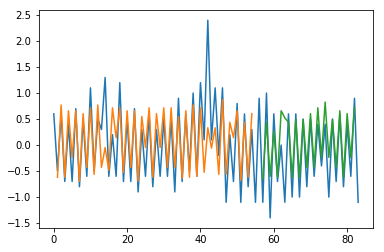

In [55]:
# TO VISUALIZE
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot = trainPredictPlot.reshape(-1, 1)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot = testPredictPlot.reshape(-1, 1)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()